In [1]:
import pandas as pd
import os
import numpy as np
np.set_printoptions(precision=4)

import catboost
from catboost import *
from catboost import CatBoostClassifier, Pool, metrics, cv
from catboost.utils import get_roc_curve, get_confusion_matrix

import matplotlib.pyplot as plt
import matplotlib.colors as colors

# other things: from sklearn.model_selection import StratifiedShuffleSplit 

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedShuffleSplit, ShuffleSplit
from sklearn.metrics import accuracy_score, roc_curve, auc, roc_auc_score, recall_score, f1_score, confusion_matrix, precision_score
from hyperopt import fmin, hp, tpe, Trials, space_eval, STATUS_OK

import shap 

import functions 

# plt.rcParams.update({'font.size': 20})


In [2]:
initial_auc = 0.8695469738994381
new_climate_auc = 0.9045051521687035

params = {
    'loss_function': 'CrossEntropy', 
    'iterations': 1000,
    'depth': 4,
    'learning_rate': 0.1,
    'eval_metric': 'AUC:hints=skip_train~false',
    # 'eval_metric': metrics.AUC(),
    'custom_metric' : ['Logloss', 'Accuracy', 'AUC:hints=skip_train~false'],
    'random_seed': 42,
    'logging_level': 'Silent',
}

# ------ best model ------

best_model_params = params.copy()
best_model_params.update({
    'use_best_model': True
})


In [3]:
df = pd.read_csv('/Users/varyabazilova/Desktop/alluvial_fans/final/!!_050723_cathments_data.csv', index_col = 0)
df = df.drop(['x_wgs', 'y_wgs', 'id'], axis = 1)
df = df[df['area_m2'] > 1000]


morphometry = ['elv_median', 'elv_range', 'area_m2', 'perim_m', 'sl_median', 
               'target', 'M', 'circularity_ratio', 'compactness']

climate = ['elv_median', 'elv_range', 'area_m2', 'perim_m', 'sl_median',
           'max_annualsum_tp', 'n_rainydays_median', 'precip95', 'cross_zero',
           'frost_days', 'tp', 'snow', 'rain', 'veg_frac', 'target', 'M',
           'circularity_ratio', 'compactness', 'mean_annual_t2m_downsc',
           'cont_permafrost', 'glacier']

morphometry = df[morphometry]
climate = df[climate]


In [4]:

y = morphometry.target
X = morphometry.drop(columns=['target'])

# # # what values are categorical: 
# X['glacier'] = X['glacier'].astype(str) 
# X['cont_permafrost'] = X['cont_permafrost'].astype(str)

cat_features = list([])

seed = 42
test_size = 0.3

# morph info, stratified sampling 

In [5]:
model, auc10, accuracy10 = functions.strat_split_data_make_model_save_metrics(X=X, y=y, cat_features=cat_features, 
                                         seed = 42, n_splits=10, model_params=best_model_params)

modelM1, aucM1, accuracyM1 = functions.strat_split_data_make_model_save_metrics(X=X, y=y, cat_features=cat_features, 
                                         seed = 42, n_splits=1, model_params=best_model_params)



In [21]:
np.array(auc10).mean()

0.8846251842945276

# morph info, regular sampling 

In [7]:
model, aucReg10, accuracyReg10 = functions.split_data_make_model_save_metrics(X=X, y=y, cat_features=cat_features, 
                                         seed = 42, n_splits=10, model_params=best_model_params)

model, aucReg1, accuracyREG1 = functions.split_data_make_model_save_metrics(X=X, y=y, cat_features=cat_features, 
                                         seed = 42, n_splits=1, model_params=best_model_params)



## plot everything together 

FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator


[Text(0, 0.8400000000000001, '0.84'),
 Text(0, 0.8600000000000001, '0.86'),
 Text(0, 0.8800000000000001, '0.88'),
 Text(0, 0.9, '0.9'),
 Text(0, 0.92, '0.92'),
 Text(0, 0.9400000000000001, '0.94'),
 Text(0, 0.9600000000000001, '0.96'),
 Text(0, 0.9800000000000001, '0.98'),
 Text(0, 1.0, '1.0')]

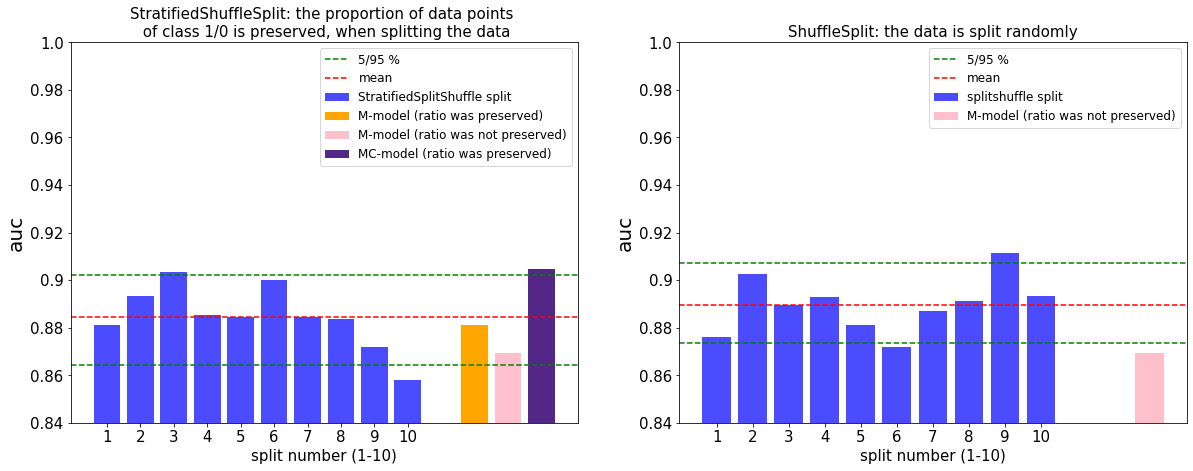

In [8]:
fig = plt.figure(figsize=(20, 7))
mosaic = fig.subplot_mosaic('''
                            ab
                            ''')
# stratified sampling
mosaic['a'].bar(range(1, len(auc10) + 1), auc10, color='blue', alpha=0.7, label = 'StratifiedSplitShuffle split')
mosaic['a'].bar(x = 12, height = aucM1, color = 'orange', label = 'M-model (ratio was preserved)')
mosaic['a'].bar(x = 13, height = initial_auc, color = 'pink', label = 'M-model (ratio was not preserved)')
# mosaic['a'].bar(x = 14, height = new_climate_auc, color = 'magenta', label = 'NEW model incl. climate data')
mosaic['a'].bar(x = 14, height = new_climate_auc, color = plt.cm.PuOr(0.9), label = 'MC-model (ratio was preserved)')


mosaic['a'].axhline(y=np.percentile(auc10, 95), color='green', linestyle = '--', label = '5/95 %')
mosaic['a'].axhline(y=np.percentile(auc10, 5), color='green', linestyle = '--')
mosaic['a'].axhline(y=np.mean(auc10), color = 'red', linestyle = '--', label = 'mean')



# regular sampling
mosaic['b'].bar(range(1, len(aucReg10) + 1), aucReg10, color='blue', alpha=0.7, label = 'splitshuffle split')
# mosaic['b'].bar(x = 12, height = aucC1, color = 'orange', label = 'new model with ')
mosaic['b'].bar(x = 13, height = initial_auc, color = 'pink', label = 'M-model (ratio was not preserved)')

mosaic['b'].axhline(y=np.percentile(aucReg10, 95), color='green', linestyle = '--', label = '5/95 %')
mosaic['b'].axhline(y=np.percentile(aucReg10, 5), color='green', linestyle = '--')
mosaic['b'].axhline(y=np.mean(aucReg10), color = 'red', linestyle = '--', label = 'mean')


# mosaic['a'].set_ylim(0.84,1) 
# mosaic['b'].set_ylim(0.84,1) 
# mosaic['a'].legend(fontsize=12)
# mosaic['b'].legend(fontsize=12)


# mosaic['a'].set_title('StratifiedShuffleSplit: the proportion of data points \n of class 1/0 is preserved, when splitting the data', fontsize = 15)
# mosaic['b'].set_title('ShuffleSplit: the data is split randomly', fontsize = 15)

# mosaic['a'].set_xticks(range(1, len(aucReg10) + 5), fontsize = 15)
# mosaic['b'].set_xticks(range(1, len(aucReg10) + 4), fontsize = 15)

# mosaic['a'].set_ylabel('auc', fontsize = 15)
# mosaic['b'].set_ylabel('auc', fontsize = 15)


# mosaic['a'].set_xlabel('split number (1-10)', fontsize = 15)
# mosaic['b'].set_xlabel('split number (1-10)', fontsize = 15)



mosaic['a'].set_ylim(0.84, 1) 
mosaic['b'].set_ylim(0.84, 1) 
mosaic['a'].legend(fontsize=12)
mosaic['b'].legend(fontsize=12)


mosaic['a'].set_title('StratifiedShuffleSplit: the proportion of data points \n of class 1/0 is preserved, when splitting the data', fontsize = 15)
mosaic['b'].set_title('ShuffleSplit: the data is split randomly', fontsize = 15)

mosaic['a'].set_xticks(range(1, len(aucReg10) + 1))#, fontsize = 20)
mosaic['b'].set_xticks(range(1, len(aucReg10) + 1))#, fontsize = 20)
mosaic['a'].set_xticklabels(range(1, len(aucReg10) + 1), fontsize=15)
mosaic['b'].set_xticklabels(range(1, len(aucReg10) + 1), fontsize=15)


mosaic['a'].set_ylabel('auc', fontsize = 15)
mosaic['b'].set_ylabel('auc', fontsize = 15)


mosaic['a'].set_xlabel('split number (1-10)', fontsize = 15)
mosaic['b'].set_xlabel('split number (1-10)', fontsize = 15)



mosaic['a'].set_ylabel('auc', fontsize = 20)
mosaic['b'].set_ylabel('auc', fontsize = 20)


mosaic['a'].set_xlabel('split number (1-10)', fontsize = 15)
mosaic['b'].set_xlabel('split number (1-10)', fontsize = 15)

mosaic['a'].set_yticklabels(labels=np.round(np.arange(0.84, 1.02, 0.02), 2), fontsize=15)
mosaic['b'].set_yticklabels(labels=np.round(np.arange(0.84, 1.02, 0.02), 2), fontsize=15)



# plt.savefig('out/removed_points/StratifiedShuffleSplit_together_with_regular_M_model.png', dpi = 300, bbox_inches = 'tight')


Text(0.5, 0, 'split number (1-10)')

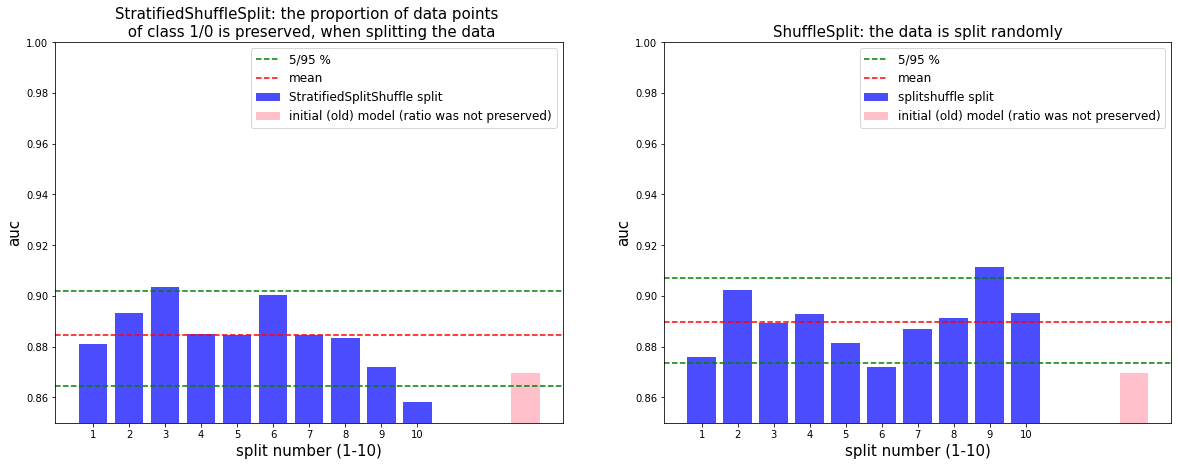

In [9]:
fig = plt.figure(figsize=(20, 7))
mosaic = fig.subplot_mosaic('''
                            ab
                            ''')
# stratified sampling
mosaic['a'].bar(range(1, len(auc10) + 1), auc10, color='blue', alpha=0.7, label = 'StratifiedSplitShuffle split')
# mosaic['a'].bar(x = 12, height = aucC1, color = 'orange', label = 'new model (ratio was preserved)')
mosaic['a'].bar(x = 13, height = initial_auc, color = 'pink', label = 'initial (old) model (ratio was not preserved)')

mosaic['a'].axhline(y=np.percentile(auc10, 95), color='green', linestyle = '--', label = '5/95 %')
mosaic['a'].axhline(y=np.percentile(auc10, 5), color='green', linestyle = '--')
mosaic['a'].axhline(y=np.mean(auc10), color = 'red', linestyle = '--', label = 'mean')



# regular sampling
mosaic['b'].bar(range(1, len(aucReg10) + 1), aucReg10, color='blue', alpha=0.7, label = 'splitshuffle split')
# mosaic['b'].bar(x = 12, height = aucC1, color = 'orange', label = 'new model with ')
mosaic['b'].bar(x = 13, height = initial_auc, color = 'pink', label = 'initial (old) model (ratio was not preserved)')

mosaic['b'].axhline(y=np.percentile(aucReg10, 95), color='green', linestyle = '--', label = '5/95 %')
mosaic['b'].axhline(y=np.percentile(aucReg10, 5), color='green', linestyle = '--')
mosaic['b'].axhline(y=np.mean(aucReg10), color = 'red', linestyle = '--', label = 'mean')


mosaic['a'].set_ylim(0.85,1) 
mosaic['b'].set_ylim(0.85,1) 
mosaic['a'].legend(fontsize=12)
mosaic['b'].legend(fontsize=12)


mosaic['a'].set_title('StratifiedShuffleSplit: the proportion of data points \n of class 1/0 is preserved, when splitting the data', fontsize = 15)
mosaic['b'].set_title('ShuffleSplit: the data is split randomly', fontsize = 15)

mosaic['a'].set_xticks(range(1, len(aucReg10) + 1), fontsize = 20)
mosaic['b'].set_xticks(range(1, len(aucReg10) + 1), fontsize = 15)

mosaic['a'].set_ylabel('auc', fontsize = 15)
mosaic['b'].set_ylabel('auc', fontsize = 15)


mosaic['a'].set_xlabel('split number (1-10)', fontsize = 15)
mosaic['b'].set_xlabel('split number (1-10)', fontsize = 15)

# plt.show()

# plt.savefig('out/removed_points/StratifiedShuffleSplit_together_with_regular_only_morph.png', dpi = 300, bbox_inches = 'tight')

In [10]:
aucM1

[0.8810996120868582]

# save new predictions

In [11]:
# make predictions 
model = modelM1[0]

y_result = model.predict(X)
probs = model.predict_proba(X)
probs = probs[:,1]


# calculate confusions 

df['y_result'] = y_result
df['y_result_probs'] = probs

df['result_True'] = df.target + df.y_result # TP = 2, TN = 0


# this is the column to see the "confusuon" situations
# TP = 2, TN = 0
# FP = -1, FN = 1
df['diff_res'] = np.where(df.result_True != 1, df.result_True, (df.target - df.y_result)) 

# Then, create a new column 'confusion' based on the condition 'diff_res' == 1
df['confusion'] = np.where(df['diff_res'] == 1, 'FN',  # False Negative
                           np.where(df['diff_res'] == 2, 'TP',  # True Positive
                                    np.where(df['diff_res'] == -1, 'FP',  # False Positive
                                             np.where(df['diff_res'] == 0, 'TN', 'Unknown'))))  # True Negative and Unknown

# save predictions
# df.to_csv('out/removed_points/20240711_new_model_predictions_output_MORPH.csv')

In [12]:
aucM1

[0.8810996120868582]

In [13]:
df.confusion.value_counts()

TP    939
TN    567
FP    163
FN    124
Name: confusion, dtype: int64

In [14]:

correct = 931 + 591
wrong = 147 + 137

total = len(df)

percent_correct = (correct * 100)/total 
percent_wrong = (wrong * 100) / total

print('precent of wrong classifications:',percent_wrong)

precent of wrong classifications: 15.839375348577802


# model meaning etc 

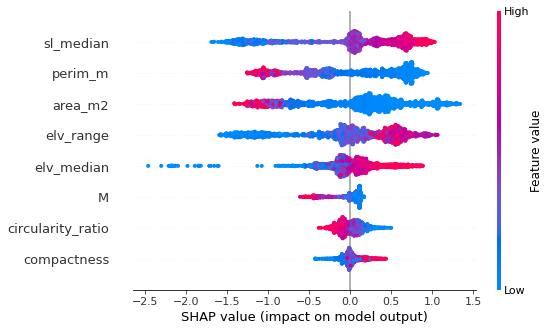

In [15]:
explainer = shap.TreeExplainer(model)

shap_values = explainer.shap_values(X)
shap.summary_plot(shap_values, X, max_display=20,show=False)


(array([-3. , -2.5, -2. , -1.5, -1. , -0.5,  0. ,  0.5,  1. ,  1.5,  2. ]),
 [Text(-3.0, 0, '−3.0'),
  Text(-2.5, 0, '−2.5'),
  Text(-2.0, 0, '−2.0'),
  Text(-1.5, 0, '−1.5'),
  Text(-1.0, 0, '−1.0'),
  Text(-0.5, 0, '−0.5'),
  Text(0.0, 0, '0.0'),
  Text(0.5, 0, '0.5'),
  Text(1.0, 0, '1.0'),
  Text(1.5, 0, '1.5'),
  Text(2.0, 0, '2.0')])

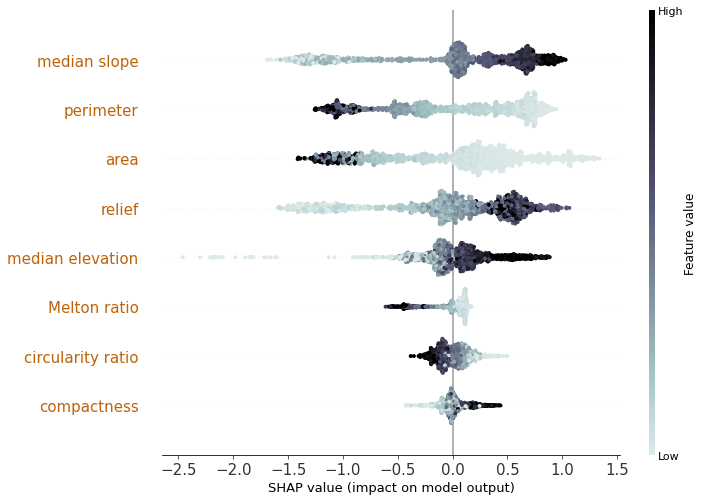

In [16]:
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

cmap = plt.get_cmap('bone_r')
cut_cmap = truncate_colormap(cmap, 0.1, 1)

features = ['median slope', 'perimeter', 'area', 'relief', 'median elevation', 
            'Melton ratio', 'circularity ratio', 'compactness']

orange = plt.cm.PuOr(0.125)
my_colors = [orange, orange, orange, orange, orange,
             orange, orange, orange]


# shap.summary_plot(shap_values, X, show=False, cmap=cut_cmap, plot_size=(10, 7))

shap.summary_plot(shap_values, X, show=False, cmap=cut_cmap,plot_size=(10, 7))

for ticklabel, tickcolor in zip(plt.gca().get_yticklabels(), my_colors[::-1]):
    ticklabel.set_color(tickcolor)

plt.yticks(range(len(features)), features[::-1], fontsize=15)
# plt.yticks(range(len(features)), features, fontsize=15) # this is upside down
plt.xticks(fontsize=15)

# plt.show()
# plt.savefig('out/removed_points/shap_values_only_morph.png', dpi = 300, bbox_inches = 'tight')

# roc curve